In [18]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

from ufc.load_data import read_scraped_odds, read_ufc_data

In [4]:
# odds_df = read_scraped_odds()

In [19]:
ufc_df = read_ufc_data()

In [20]:
odds_df = ufc_df[['favourite', 'underdog', 'favourite_odds', 'underdog_odds', 'betting_outcome']]

In [22]:
# Drop rows with inf odds or NA betting outcome
odds_df = odds_df[
    ~(
        (odds_df["favourite_odds"] == np.inf) | (odds_df["underdog_odds"] == np.inf)
    )
]

odds_df = odds_df[
    ~odds_df.betting_outcome.isna()
]

In [14]:
# Recode to favourite vs underdog
# Where equal odds - we will consider fighter1 as the favourite (minority of cases so fine to include for modelling)
# odds_df["favourite"] = np.where(odds_df["fighter1_odds"] <= odds_df["fighter2_odds"], odds_df["fighter1"], odds_df["fighter2"])
# odds_df["underdog"] = np.where(odds_df["fighter1_odds"] > odds_df["fighter2_odds"], odds_df["fighter1"], odds_df["fighter2"])
# odds_df["outcome"] = np.where(odds_df["outcome"] == odds_df["favourite"], "favourite", "underdog")

In [24]:
# % of fights where favourite won
(
    odds_df
    .groupby("betting_outcome", as_index=False)
    .agg(n = ('betting_outcome', 'count'))
    .assign(pct = lambda df: df["n"] / sum(df["n"]))
)

,betting_outcome,n,pct
0,favourite,2221,0.651893
1,underdog,1186,0.348107


Relationship between delta of odds and likelihood of favourite winning

In [26]:
odds_df["delta_odds"] = abs(odds_df["favourite_odds"] - odds_df["underdog_odds"])

In [29]:
plot_df = odds_df.copy()

bins = [0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, float('inf')]
labels = ['0 - 0.5', '0.5 - 1', '1 - 1.5', '1.5 - 2', '2 - 2.5', '2.5 - 3', '3 - 3.5', '3.5 - 4', '4 - 4.5', '4.5 - 5', '5+']

plot_df["delta_odds_bin"] = pd.cut(plot_df['delta_odds'], bins=bins, labels=labels, right=False)

plot_df = (
    plot_df
    .groupby(["delta_odds_bin"], as_index=False)
    .agg(
        n = ('betting_outcome', lambda x: x.count()),
        pct_fav_win = ('betting_outcome', lambda x: (x == "favourite").sum() / x.count())
    )
)

plot_df = plot_df.sort_values(by='delta_odds_bin')

plot_df['delta_odds_bin'] = plot_df['delta_odds_bin'].astype(str)


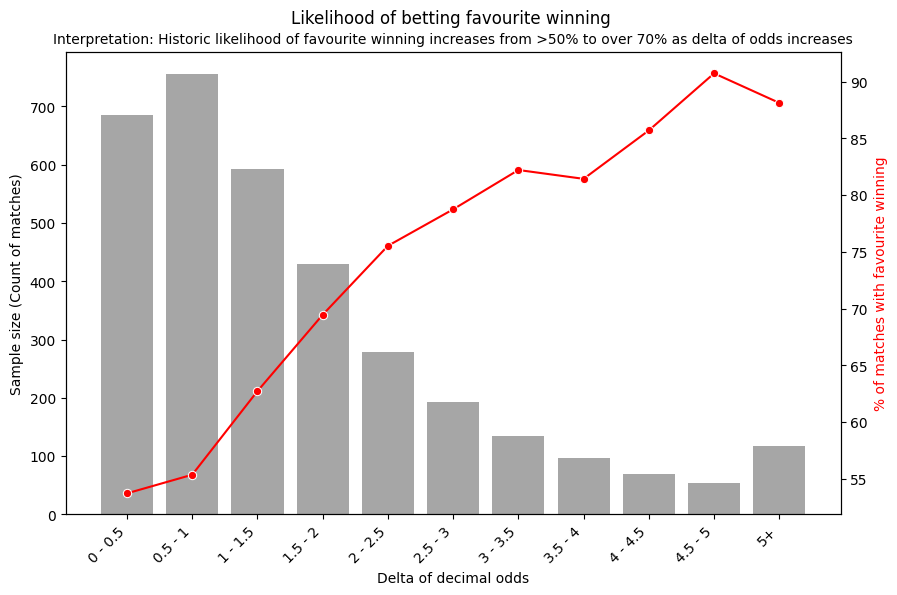

In [30]:
fig, ax1 = plt.subplots(figsize=(10, 6))

sns.barplot(x=plot_df['delta_odds_bin'], y=plot_df['n'], alpha=0.7, ax=ax1, zorder=2, color="grey")
ax1.set_ylabel('Sample size (Count of matches)')
ax1.set_xlabel('Delta of decimal odds')
plt.xticks(rotation=45, ha='right')

ax2 = ax1.twinx()

sns.lineplot(x=plot_df['delta_odds_bin'], y=plot_df['pct_fav_win'] * 100, marker='o', color="red", ax=ax2, zorder=3)
ax2.set_ylabel('% of matches with favourite winning', color="red")

plt.title("Likelihood of betting favourite winning \n")

info_text = "Interpretation: Historic likelihood of favourite winning increases from >50% to over 70% as delta of odds increases"
plt.text(0.5, 1.02, info_text, ha='center', fontsize=10, transform=ax1.transAxes)

plt.show()
